In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import os
from sklearn import linear_model
import glob
from pathlib import Path
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
Col_message = ["Time(sec)", "Event Type", "Order ID", "Size", "Price", "Direction", "N/A"]
Col_order = ["Ask Price1", "Ask Size1", "Bid Price1", "Bid Size1", "Ask Price2", "Ask Size2", \
             "Bid Price2", "Bid Size2"]

In [3]:
## Kyles Lambda: 

In [4]:
delta = 300 #sec 
trade_start = 34200 #sec
trade_end = 57600 # sec
num_steps = int((trade_end-trade_start) / delta)

In [5]:
folder = "MM-2022-Coursework-Data (1)"
filenames_order = []
filenames_message = []

for files in Path(folder).glob('*orderbook_2.csv'):
    filenames_order.append(files)
filenames_order.sort()

for files2 in Path(folder).glob('*message_2.csv'):
    filenames_message.append(files2)
filenames_message.sort()

In [6]:
%%capture --no-display
vol_buy = []
vol_sell = [] 
timestamps = []

for file in filenames_message:
    df_message = pd.read_csv(file, names= Col_message)
    
    df_market_orders = df_message[(df_message["Event Type"] >= 4) & (df_message["Event Type"] < 7)]
    df_market_orders_buy = df_market_orders[df_market_orders["Direction"] == -1]
    df_market_orders_sell = df_market_orders[df_market_orders["Direction"] == 1]
    
    
    
    vbuy = []
    time_tmp = [] 
    for i in range(1,num_steps+1):
        time_tmp.append(df_message[(df_message["Time(sec)"] >= ((i-1)*delta)+trade_start)].index[0])
        
        tmp = np.sum(df_market_orders_buy[(df_market_orders_buy["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                          (df_market_orders_buy["Time(sec)"] < (i*delta)+trade_start)]["Size"])
        vbuy.append(tmp)
    
    vsell = []
    for j in range(1,num_steps+1):
        tmp = np.sum(df_market_orders_sell[(df_market_orders_sell["Time(sec)"] >= ((j-1)*delta)+trade_start) & \
                                          (df_market_orders_sell["Time(sec)"] < (j*delta)+trade_start)]["Size"])
        vsell.append(tmp)
    
    time_tmp.append(df_message.index[-1])
    
    timestamps.append(time_tmp)
    vol_buy.append(vbuy)
    vol_sell.append(vsell)

In [7]:
midprice_difference = [] 
counter = 0

for file in filenames_order:
    df_order = pd.read_csv(file, names= Col_order)
    
    df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5
    
    midprice_tmp = []
    
    for i in range(0,num_steps+1):
        tmp = df_order.iloc[timestamps[counter][i]]["Midprice"]
        midprice_tmp.append(tmp)
    
    midprice_tmp = np.array(midprice_tmp[1:]) - np.array(midprice_tmp[:-1])
    
    midprice_difference.append(midprice_tmp)
    counter += 1
    

In [8]:
## create vol difference
vol_diff = []
npvol_buy = np.array(vol_buy)
npvol_sell = np.array(vol_sell)

for i in range(len(vol_buy)):
    tmp = npvol_buy[i] - npvol_sell[i]
    vol_diff.append(tmp)

In [9]:
npvol_diff = np.array(vol_diff)

In [10]:
## create arrays for the same timestamps: vol and midprice: 
time_midprice = [] 
time_voldiff = [] 

for i in range(npvol_diff.shape[1]):
    tmp1 = []
    tmp2 = []
    for j in range(npvol_diff.shape[0]):
        tmp1.append(npvol_diff[j][i])
        tmp2.append(midprice_difference[j][i])
      
    time_voldiff.append(tmp1)
    time_midprice.append(tmp2)

In [11]:
nptime_voldiff = np.array(time_voldiff)
nptime_middiff = np.array(time_midprice)

In [12]:
nptime_middiff = nptime_middiff/10_000

In [13]:
#create linear regression models:
klambda = []
for i in range(nptime_middiff.shape[0]):
    y = nptime_middiff[i].reshape(-1,1)
    X = nptime_voldiff[i].reshape(-1,1)
    model = linear_model.LinearRegression(fit_intercept=True).fit(X,y)
    klambda.append(model.coef_[0][0])
    

In [14]:
#klambda

In [15]:
time_steps = []

for i in range(num_steps):
    tmp = trade_start+((i+1)*delta)
    tmp2 = dt.timedelta(seconds = tmp)
    time_steps.append(str(tmp2)[:-3])

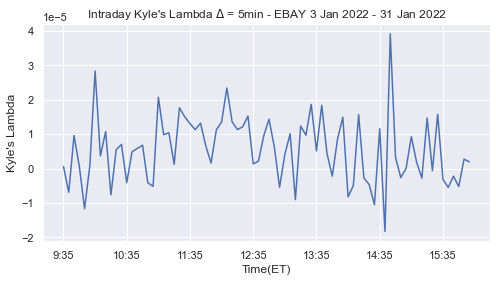

In [16]:
fig = plt.subplots(figsize=(8, 4))
plt.plot(time_steps,klambda)
plt.xticks(time_steps[::12])
plt.xlabel("Time(ET)")
plt.ylabel("Kyle's Lambda")
plt.title("Intraday Kyle's Lambda $\Delta$ = 5min - EBAY 3 Jan 2022 - 31 Jan 2022")
plt.show()

### Amihud's (il)liquidity measure

In [17]:
%%capture --no-display
mon_all = []
timestamps_2 = []

for file in filenames_message:
    df_message = pd.read_csv(file, names= Col_message)
    
    df_market_orders = df_message[(df_message["Event Type"] >= 4) & (df_message["Event Type"] < 7)]
    #df_market_orders_buy = df_market_orders[df_market_orders["Direction"] == -1]
    #df_market_orders_sell = df_market_orders[df_market_orders["Direction"] == 1]
    
    mon = []
    time_tmp = []
    for i in range(1,num_steps+1):
        time_tmp.append(df_message[(df_message["Time(sec)"] >= ((i-1)*delta)+trade_start)].index[0])
        
        tmp_mon = np.sum(np.array(df_market_orders[(df_market_orders["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                          (df_market_orders["Time(sec)"] < (i*delta)+trade_start)]["Size"])* \
                          (np.array(df_market_orders[(df_market_orders["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                          (df_market_orders["Time(sec)"] < (i*delta)+trade_start)]["Price"])/10_000))

        mon.append(tmp_mon)
    
    time_tmp.append(df_message.index[-1])
    
    timestamps_2.append(time_tmp)
    mon_all.append(mon)

In [18]:
## get price diffs
midprice_difference_norm = [] 
counter_2 = 0

for file in filenames_order:
    df_order = pd.read_csv(file, names= Col_order)
    
    df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5
    
    midprice_tmp = []
    
    for i in range(0,num_steps+1):
        tmp = df_order.iloc[timestamps_2[counter_2][i]]["Midprice"]
        midprice_tmp.append(tmp)
    
    midprice_tmp = (np.array(midprice_tmp[1:]) - np.array(midprice_tmp[:-1])) / np.array(midprice_tmp[:-1])
    
    midprice_difference_norm.append(np.abs(midprice_tmp))
    counter_2 += 1
    

In [19]:
np_mid_norm = np.array(midprice_difference_norm)
np_mon_all = np.array(mon_all)

In [20]:
## create arrays for the same timestamps: mon and midprice_norm: (reorder arrays for intraday analysis)
time_mid_norm = [] 
time_mon_all = [] 

for i in range(np_mon_all.shape[1]):
    tmp1 = []
    tmp2 = []
    for j in range(np_mon_all.shape[0]):
        tmp1.append(np_mon_all[j][i])
        tmp2.append(np_mid_norm[j][i])
      
    time_mid_norm.append(tmp2)
    time_mon_all.append(tmp1)

In [21]:
nptime_mon = np.array(time_mon_all)
nptime_mid_norm = np.array(time_mid_norm)

In [22]:
# compute amihuds measure 
illiq = [] 
n = nptime_mon.shape[1]

for j in range(nptime_mon.shape[0]):
    sum_tmp = 0
    for i in range(n):
        quotient = nptime_mid_norm[j][i] / nptime_mon[j][i]
        sum_tmp += quotient
    sum_tmp = sum_tmp / n
    illiq.append(sum_tmp)


In [23]:
#illiq

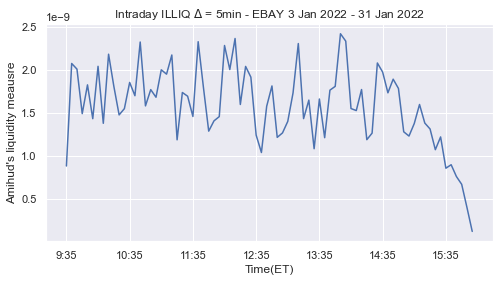

In [24]:
fig_2 = plt.subplots(figsize=(8, 4))
plt.plot(time_steps,illiq)
plt.xticks(time_steps[::12])
plt.xlabel("Time(ET)")
plt.ylabel("Amihud's liquidity meausre")
plt.title("Intraday ILLIQ $\Delta$ = 5min - EBAY 3 Jan 2022 - 31 Jan 2022")
plt.show()

### Average relative spread for reference: 

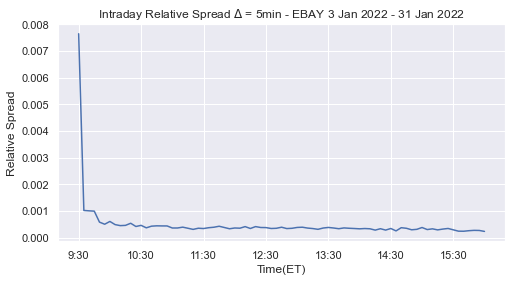

In [25]:
# compute relative spread 
## get price diffs
rel_spread = [] 
counter_3 = 0

for file in filenames_order:
    df_order = pd.read_csv(file, names= Col_order)
    
    df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5
    df_order["Spread"] = (df_order["Ask Price1"] - df_order["Bid Price1"])
    
    spread_tmp = []
    
    for i in range(0,num_steps+1):
        tmp = df_order.iloc[timestamps_2[counter_3][i]]["Spread"]/df_order.iloc[timestamps_2[counter_3][i]]["Midprice"]
        spread_tmp.append(tmp)
    
    rel_spread.append(spread_tmp)
    counter_2 += 1

nprel_spread = np.array(rel_spread)

time_relspread = [] 

for i in range(nprel_spread.shape[1]):
    tmp1 = []
    for j in range(nprel_spread.shape[0]):
        tmp1.append(nprel_spread[j][i])
      
    time_relspread.append(tmp1)
    
np_spread = np.array(time_relspread)
np_spread_average = [np.mean(np_spread[i]) for i in range(np_spread.shape[0])]
time_steps_2 = time_steps[:]
time_steps_2.insert(0,'9:30',)

#plot
fig_3 = plt.subplots(figsize=(8, 4))
plt.plot(time_steps_2,np_spread_average)
plt.xticks(time_steps_2[::12])
plt.xlabel("Time(ET)")
plt.ylabel("Relative Spread")
plt.title("Intraday Relative Spread $\Delta$ = 5min - EBAY 3 Jan 2022 - 31 Jan 2022")
plt.show()


### We now get the results for different values for $\Delta$

In [26]:
# Kyle's Lambda:

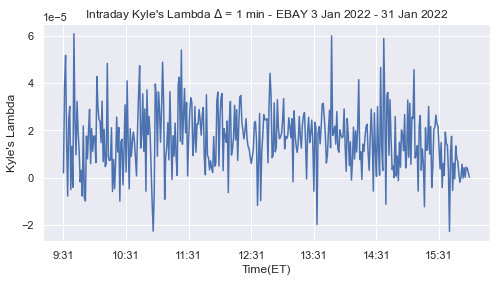

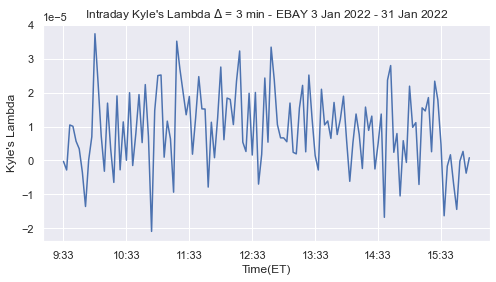

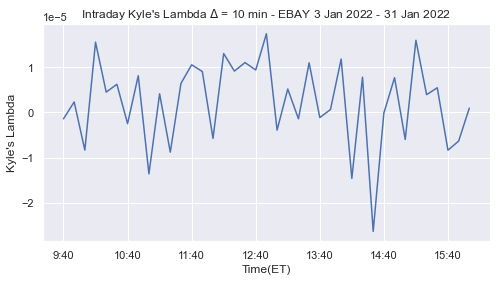

In [27]:
%%capture --no-display
deltas = [60,180,600]
trade_start = 34200 #sec
trade_end = 57600 # sec

for delta in deltas:
    num_steps = int((trade_end-trade_start) / delta)
    # volumes 
    vol_buy = []
    vol_sell = [] 
    timestamps = []

    for file in filenames_message:
        df_message = pd.read_csv(file, names= Col_message)

        df_market_orders = df_message[(df_message["Event Type"] >= 4) & (df_message["Event Type"] < 7)]
        df_market_orders_buy = df_market_orders[df_market_orders["Direction"] == -1]
        df_market_orders_sell = df_market_orders[df_market_orders["Direction"] == 1]



        vbuy = []
        time_tmp = [] 
        for i in range(1,num_steps+1):
            time_tmp.append(df_message[(df_message["Time(sec)"] >= ((i-1)*delta)+trade_start)].index[0])

            tmp = np.sum(df_market_orders_buy[(df_market_orders_buy["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                              (df_market_orders_buy["Time(sec)"] < (i*delta)+trade_start)]["Size"])
            vbuy.append(tmp)

        vsell = []
        for j in range(1,num_steps+1):
            tmp = np.sum(df_market_orders_sell[(df_market_orders_sell["Time(sec)"] >= ((j-1)*delta)+trade_start) & \
                                              (df_market_orders_sell["Time(sec)"] < (j*delta)+trade_start)]["Size"])
            vsell.append(tmp)

        time_tmp.append(df_message.index[-1])

        timestamps.append(time_tmp)
        vol_buy.append(vbuy)
        vol_sell.append(vsell)
    #midprice    
    midprice_difference = [] 
    counter = 0

    for file in filenames_order:
        df_order = pd.read_csv(file, names= Col_order)

        df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5

        midprice_tmp = []

        for i in range(0,num_steps+1):
            tmp = df_order.iloc[timestamps[counter][i]]["Midprice"]
            midprice_tmp.append(tmp)

        midprice_tmp = np.array(midprice_tmp[1:]) - np.array(midprice_tmp[:-1])

        midprice_difference.append(midprice_tmp)
        counter += 1


    ## create vol difference
    vol_diff = []
    npvol_buy = np.array(vol_buy)
    npvol_sell = np.array(vol_sell)

    for i in range(len(vol_buy)):
        tmp = npvol_buy[i] - npvol_sell[i]
        vol_diff.append(tmp)
    npvol_diff = np.array(vol_diff)


    ## create arrays for the same timestamps: vol and midprice: 
    time_midprice = [] 
    time_voldiff = [] 

    for i in range(npvol_diff.shape[1]):
        tmp1 = []
        tmp2 = []
        for j in range(npvol_diff.shape[0]):
            tmp1.append(npvol_diff[j][i])
            tmp2.append(midprice_difference[j][i])

        time_voldiff.append(tmp1)
        time_midprice.append(tmp2)

    nptime_voldiff = np.array(time_voldiff)
    nptime_middiff = np.array(time_midprice)
    nptime_middiff = nptime_middiff/10_000


    #create linear regression models:
    klambda = []
    for i in range(nptime_middiff.shape[0]):
        y = nptime_middiff[i].reshape(-1,1)
        X = nptime_voldiff[i].reshape(-1,1)
        model = linear_model.LinearRegression().fit(X,y)
        klambda.append(model.coef_[0][0])

    #get time steps
    time_steps = []

    for i in range(num_steps):
        tmp = trade_start+((i+1)*delta)
        tmp2 = dt.timedelta(seconds = tmp)
        time_steps.append(str(tmp2)[:-3])

    #plot
    fig = plt.subplots(figsize=(8, 4))
    plt.plot(time_steps,klambda)
    plt.xticks(time_steps[::int((3600/delta))])
    plt.xlabel("Time(ET)")
    plt.ylabel("Kyle's Lambda")
    plt.title("Intraday Kyle's Lambda $\Delta$ = %.d min - EBAY 3 Jan 2022 - 31 Jan 2022" % int(delta/60))
    plt.show()

In [28]:
# Amihud's (il)liquidity measure:

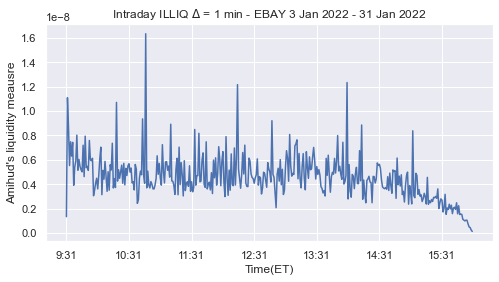

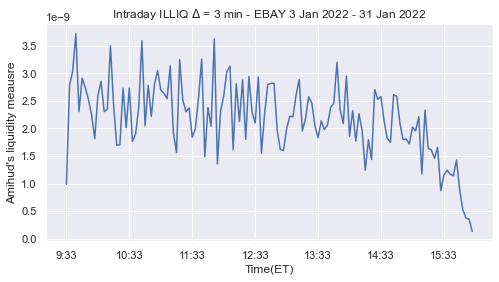

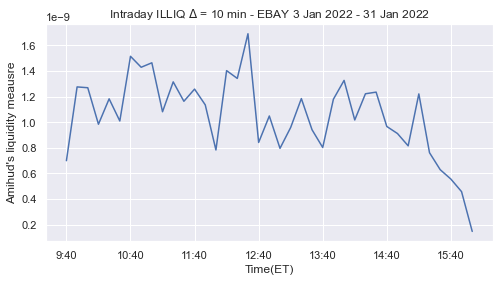

In [29]:
%%capture --no-display
deltas = [60,180,600]
trade_start = 34200 #sec
trade_end = 57600 # sec

for delta in deltas:
    num_steps = int((trade_end-trade_start) / delta)
    mon_all = []
    timestamps_2 = []

    for file in filenames_message:
        df_message = pd.read_csv(file, names= Col_message)

        df_market_orders = df_message[(df_message["Event Type"] >= 4) & (df_message["Event Type"] < 7)]

        mon = []
        time_tmp = []
        for i in range(1,num_steps+1):
            time_tmp.append(df_message[(df_message["Time(sec)"] >= ((i-1)*delta)+trade_start)].index[0])

            tmp_mon = np.sum(np.array(df_market_orders[(df_market_orders["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                              (df_market_orders["Time(sec)"] < (i*delta)+trade_start)]["Size"])* \
                              (np.array(df_market_orders[(df_market_orders["Time(sec)"] >= ((i-1)*delta)+trade_start) & \
                                              (df_market_orders["Time(sec)"] < (i*delta)+trade_start)]["Price"])/10_000))

            mon.append(tmp_mon)

        time_tmp.append(df_message.index[-1])

        timestamps_2.append(time_tmp)
        mon_all.append(mon)

    ## get price diffs
    midprice_difference_norm = [] 
    counter_2 = 0

    for file in filenames_order:
        df_order = pd.read_csv(file, names= Col_order)

        df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5

        midprice_tmp = []

        for i in range(0,num_steps+1):
            tmp = df_order.iloc[timestamps_2[counter_2][i]]["Midprice"]
            midprice_tmp.append(tmp)

        midprice_tmp = (np.array(midprice_tmp[1:]) - np.array(midprice_tmp[:-1])) / np.array(midprice_tmp[:-1])

        midprice_difference_norm.append(np.abs(midprice_tmp))
        counter_2 += 1

    np_mid_norm = np.array(midprice_difference_norm)
    np_mon_all = np.array(mon_all)


    ## create arrays for the same timestamps: mon and midprice_norm: (reorder arrays for intraday analysis)
    time_mid_norm = [] 
    time_mon_all = [] 

    for i in range(np_mon_all.shape[1]):
        tmp1 = []
        tmp2 = []
        for j in range(np_mon_all.shape[0]):
            tmp1.append(np_mon_all[j][i])
            tmp2.append(np_mid_norm[j][i])

        time_mon_all.append(tmp1)
        time_mid_norm.append(tmp2)

    nptime_mon = np.array(time_mon_all)
    nptime_mid_norm = np.array(time_mid_norm)

    # compute amihuds measure 
    illiq = [] 
    n = nptime_mon.shape[1]
    if (delta == 60):
        for j in range(nptime_mon.shape[0]):
            sum_tmp = 0
            for i in range(n):
                quotient = nptime_mid_norm[j][i] / (nptime_mon[j][i]+1e-11)
                sum_tmp += quotient
            sum_tmp = sum_tmp / n
            illiq.append(sum_tmp)
        np_illiq = np.array(illiq)
        for i in range(np_illiq.shape[0]):
            if np_illiq[i] > (3*np.mean(np_illiq)):
                np_illiq[i] = np.mean(np_illiq)
    elif (delta != 60):
        for j in range(nptime_mon.shape[0]):
            sum_tmp = 0
            for i in range(n):
                quotient = nptime_mid_norm[j][i] / nptime_mon[j][i]
                sum_tmp += quotient
            sum_tmp = sum_tmp / n
            illiq.append(sum_tmp)
        np_illiq = np.array(illiq)
        
    #get time steps
    time_steps = []

    for i in range(num_steps):
        tmp = trade_start+((i+1)*delta)
        tmp2 = dt.timedelta(seconds = tmp)
        time_steps.append(str(tmp2)[:-3])

    #plot
    fig_2 = plt.subplots(figsize=(8, 4))
    plt.plot(time_steps,np_illiq)
    plt.xticks(time_steps[::int(3600/delta)])
    plt.xlabel("Time(ET)")
    plt.ylabel("Amihud's liquidity meausre")
    plt.title("Intraday ILLIQ $\Delta$ = %.d min - EBAY 3 Jan 2022 - 31 Jan 2022" % int(delta/60))
    plt.show()

In [30]:
# Reference Rel. Spreads:

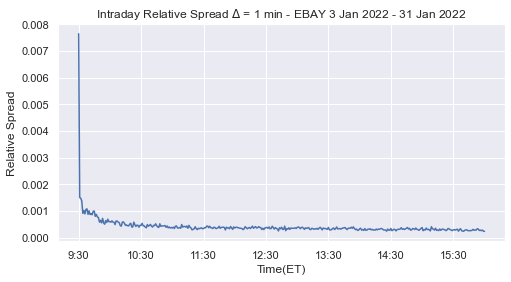

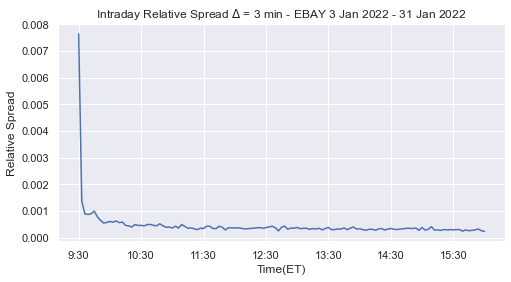

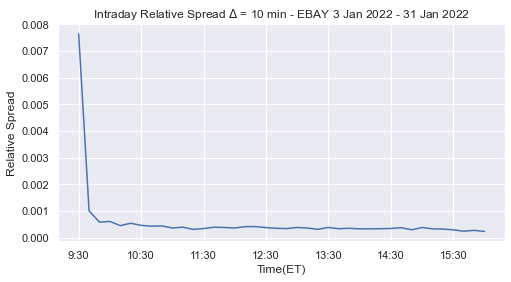

In [31]:
%%capture --no-display

deltas = [60,180,600]
trade_start = 34200 #sec
trade_end = 57600 # sec

for delta in deltas:
    num_steps = int((trade_end-trade_start) / delta)
    rel_spread = [] 
    counter_3 = 0
    
    #get time steps
    time_steps = []

    for i in range(num_steps):
        tmp = trade_start+((i+1)*delta)
        tmp2 = dt.timedelta(seconds = tmp)
        time_steps.append(str(tmp2)[:-3])
        
        
    timestamps_2 = []

    for file in filenames_message:
        df_message = pd.read_csv(file, names= Col_message)
        time_tmp = []
        
        for i in range(1,num_steps+1):
            time_tmp.append(df_message[(df_message["Time(sec)"] >= ((i-1)*delta)+trade_start)].index[0])

        time_tmp.append(df_message.index[-1])
        timestamps_2.append(time_tmp)
      

    for file in filenames_order:
        df_order = pd.read_csv(file, names= Col_order)

        df_order["Midprice"] = (df_order["Ask Price1"] + df_order["Bid Price1"])*0.5
        df_order["Spread"] = (df_order["Ask Price1"] - df_order["Bid Price1"])

        spread_tmp = []

        for i in range(0,num_steps+1):
            tmp = df_order.iloc[timestamps_2[counter_3][i]]["Spread"]/df_order.iloc[timestamps_2[counter_3][i]]["Midprice"]
            spread_tmp.append(tmp)

        rel_spread.append(spread_tmp)
        counter_2 += 1

    nprel_spread = np.array(rel_spread)

    time_relspread = [] 

    for i in range(nprel_spread.shape[1]):
        tmp1 = []
        for j in range(nprel_spread.shape[0]):
            tmp1.append(nprel_spread[j][i])

        time_relspread.append(tmp1)

    np_spread = np.array(time_relspread)
    np_spread_average = [np.mean(np_spread[i]) for i in range(np_spread.shape[0])]
    time_steps_2 = time_steps[:]
    time_steps_2.insert(0,'9:30')

    #plot
    fig_3 = plt.subplots(figsize=(8, 4))
    plt.plot(time_steps_2,np_spread_average)
    plt.xticks(time_steps_2[::int(3600/delta)])
    plt.xlabel("Time(ET)")
    plt.ylabel("Relative Spread")
    plt.title("Intraday Relative Spread $\Delta$ = %.d min - EBAY 3 Jan 2022 - 31 Jan 2022" % int(delta/60))
    plt.show()